### For given aoi, prepare sentinel image with NDVI

In [1]:
import os
import geopandas as gp
import numpy as np
import rasterio
import re
import tempfile
import pyproj
import uuid
import math

from rasterio.windows import Window
from rasterio import Affine
from shapely.geometry import Polygon, box
from shapely.ops import transform
from pathlib import Path
from datetime import datetime, timedelta
from sentinel2download.downloader import Sentinel2Downloader
from sentinel2download.overlap import Sentinel2Overlap

In [90]:
def crop(input_path, output_path, polygon, name, date):
    with rasterio.open(input_path) as src:
        out_image, out_transform = rasterio.mask.mask(src, [polygon], crop=True)
        print(out_transform)
        out_meta = src.meta
        
        out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

    with rasterio.open(output_path, "w", **out_meta) as dest:
        dest.update_tags(name=name, start_date=date, end_date=date)
        dest.write(out_image)

In [3]:
def convert(input_path, output_path, driver='GTiff'):
    with rasterio.open(input_path) as src:
        raster = src.read()
        crs = str(src.crs)
        
        print("CONVERTED CRS")
        print(crs)
                
        kwargs = src.meta.copy()
        kwargs.update({'driver': driver})
        
        
        with rasterio.open(output_path, 'w', **kwargs) as dst:
            dst.write(raster)
        return crs

In [25]:
def to_crs(poly, target, current='EPSG:4326'):
    print(f"TARGET CRS: {target}")
    project = pyproj.Transformer.from_crs(pyproj.CRS(current), pyproj.CRS(target), always_xy=True).transform
    transformed_poly = transform(project, poly)
    return transformed_poly 

In [5]:
def generate_dates(delta=20, format='%Y-%m-%d'):
    now = datetime.now()
    end_date = datetime(now.year, now.month, now.day)

    while True:
        start_date = end_date - timedelta(days=delta)
        yield datetime.strftime(start_date, format), datetime.strftime(end_date, format)
        end_date = start_date

In [6]:
def load_images(aoi_path, api_key, output_dir):
    
    overlap = Sentinel2Overlap(aoi_path)
    tiles = overlap.overlap()
    print(f"Overlap tiles: {tiles}")
    
    loader = Sentinel2Downloader(api_key)
    loadings = dict()
    for tile in tiles:
        print(f"Loading images for tile: {tile}...")
        for start_date, end_date in generate_dates():
            print(f"Dates from {start_date} to {end_date}")
            loaded = loader.download('L2A',
                                     [tile],
                                     start_date=start_date,
                                     end_date=end_date,
                                     output_dir=output_dir,                       
                                     bands=BANDS,
                                     constraints=CONSTRAINTS)

            if loaded:
                print(f"Loading images for tile {tile} finished")
                loadings[tile] = loaded
                break
            else:
                print("No matching images")
    return loadings

In [7]:
def last_image_paths(loaded):
    date_pattern = r"_(\d+)T\d+_"
    dates = list()
    for path, _ in loaded:
        if path.endswith('.jp2'):
            search = re.search(date_pattern, path)
            date = search.group(1)
            date = datetime.strptime(date, '%Y%m%d')
            dates.append(date)
    
    last_date = max(dates)
    last_date = datetime.strftime(date, '%Y%m%d')
    paths = list()
    for path, _ in loaded:
        if path.endswith('.jp2') and last_date in path:
            paths.append(path)
    return paths, last_date

In [8]:
def filter_loadings(loadings):
    filtered = dict()
    for tile, image_paths in loadings.items():        
        paths, date = last_image_paths(image_paths)
        bands_paths = dict()
        for path in paths:
            if 'B04' in path:
                bands_paths['RED'] = path
            if 'B08' in path:
                bands_paths['NIR'] = path
            if 'TCI' in path:
                bands_paths['TCI'] = path
        filtered[tile] = dict(paths=bands_paths, date=date)
    return filtered

In [9]:
def NDVI(nir_path, red_path, save_path):
    print("Calculating NDVI...")
    # Allow division by zero
    np.seterr(divide='ignore', invalid='ignore')
    
    with rasterio.open(nir_path) as src:
        nir = src.read(1).astype(rasterio.float32)
        crs = str(src.crs)
    with rasterio.open(red_path) as src:
        red = src.read(1).astype(rasterio.float32)

    # Calculate NDVI
    ndvi = ((nir - red) / (nir + red)) 
    
    
    # mask nan values
    nan_mask = np.isnan(ndvi)
    ndvi[nan_mask] = -10000
    
    # global ndvi_ 
    # ndvi_ = ndvi.copy()
    # print("ndvi_")
    # print(ndvi_)
    
    
    # Set spatial characteristics of the output object
    kwargs = src.meta.copy()    
    kwargs.update(
        dtype=rasterio.float32,
        driver='GTiff',
        nodata=-10000,
        count = 1)
    
    # print(f"Metadata of NDVI: {kwargs}")

    # Create the file
    with rasterio.open(save_path, 'w', **kwargs) as dst:
         dst.write(ndvi.astype(rasterio.float32), 1)
    print("NDVI calculation finished")
    return crs

In [10]:
def get_path(path, layer, base, name, suffix=None):
    if layer == 'NDVI':
        stem = Path(path).stem
        stem = re.sub(r"_B\d{2}", '_NDVI', stem)
    else:
        stem = Path(path).stem
    path = os.path.join(base, f"{name}_{stem}.tif")
    if suffix:
         path += suffix
    os.makedirs(os.path.dirname(path), exist_ok=True)
    return path

In [88]:
def calculate(temp_dir, bbox, name, properties):
    """
    Preparing true color Sentinel2 and NDVI images for given AOI
    """
    print("Calculating TCI and NDVI for given AOI...")
    
    layers = ['TCI', ]
    image_paths = properties['paths']
    date = properties['date']
    
    for layer in layers:
        print(f"\nCalculating {layer}:\n")
        
        if layer == 'TCI':       
            # convert .jp2 image to .tif
            path = image_paths['TCI']
            temp_path = get_path(path, layer, temp_dir, name)    
            print(f"Save {layer} image path: {temp_path}")
            
            target_crs = convert(path , temp_path) 
            
        if layer == 'NDVI':
            path = image_paths['RED']
            temp_path = get_path(path, layer, temp_dir, name)    
            print(f"Save {layer} image path: {temp_path}")
            
            # calculate NDVI
            target_crs = NDVI(image_paths['NIR'], image_paths['RED'], temp_path)
    
        temp_output_path = get_path(path, layer, RESULTS_DIR, name, suffix=".temp")
        print(f"Temporary {layer} output path: {temp_output_path}")
    
        print("TARGET CRS")
        print(target_crs)
        bound_box = to_crs(bbox, target_crs)   
        
        print("BOUND BOX")
        print(bound_box)
        
        # crop .tif image by aoi
        crop(temp_path, temp_output_path, bound_box, name, date)    
    
        print(f"Temp file: {temp_output_path}")
        output_path = temp_output_path[:-5]
        print(f"Rename temp file: {temp_output_path} to {output_path}")
        os.rename(temp_output_path, output_path)
        
    print("Calculations finished")

### Execution part

In [81]:
NB_USER = os.getenv('NB_USER')
print(NB_USER)

jovyan


In [82]:
BASE = f"/home/{NB_USER}/work"

API_KEY = os.path.join(BASE, ".secret/sentinel2_google_api_key.json")
LOAD_DIR = os.path.join(BASE, "satellite_imagery")
SIP_DIR = os.path.join(BASE, "notebooks/sip")
RESULTS_DIR = os.path.join(BASE, "res/sip")


BANDS = {'TCI', 'B04', 'B08', }
CONSTRAINTS = {'NODATA_PIXEL_PERCENTAGE': 10.0, 'CLOUDY_PIXEL_PERCENTAGE': 5.0, }

In [83]:
aoi_path = os.path.join(BASE, "notebooks/sip/Kharkiv.geojson") # 'osnova_lake.geojson' # os.getenv('AOI')
aoi_path

'/home/jovyan/work/notebooks/sip/Kharkiv.geojson'

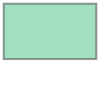

In [20]:
bbox

In [17]:
g = gp.GeoDataFrame(geometry=[bbox])

In [18]:
g

,geometry
0,"POLYGON ((38.30383 48.37815, 38.30383 50.55532..."


In [19]:
import shapely.wkt

P = shapely.wkt.loads('POLYGON ((892676.1099244957 5371935.829034151, 875610.3292751135 5613820.028189684, 617720.3438376935 5601695.805348845, 623057.0102474339 5359665.184315259, 892676.1099244957 5371935.829034151))')

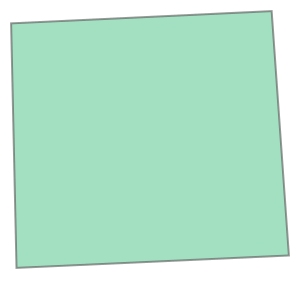

In [82]:
P

In [83]:
g = gp.GeoDataFrame(geometry=[P])

In [85]:
g

,geometry
0,"POLYGON ((892676.110 5371935.829, 875610.329 5..."


In [84]:
g.to_file(os.path.join(BASE, "notebooks/sip/Kharkiv_bbox_proj.geojson"), driver='GeoJSON')

#### Get bound box

In [84]:
aoi = gp.read_file(aoi_path)    
bbox = box(*aoi.total_bounds)

name = Path(aoi_path).stem

#### Loading images

In [85]:
loadings = load_images(aoi_path, API_KEY, LOAD_DIR)
filtered = filter_loadings(loadings)
# filtered

Overlap tiles: ['36UXA', '36UXU', '36UXV', '36UYA', '36UYB', '36UYU', '36UYV', '37UCQ', '37UCR', '37UDQ', '37UDR']
Loading images for tile: 36UXA...
Dates from 2020-11-11 to 2020-12-01
No matching images
Dates from 2020-10-22 to 2020-11-11
Loading images for tile 36UXA finished
Loading images for tile: 36UXU...
Dates from 2020-11-11 to 2020-12-01
No matching images
Dates from 2020-10-22 to 2020-11-11
Loading images for tile 36UXU finished
Loading images for tile: 36UXV...
Dates from 2020-11-11 to 2020-12-01
No matching images
Dates from 2020-10-22 to 2020-11-11
Loading images for tile 36UXV finished
Loading images for tile: 36UYA...
Dates from 2020-11-11 to 2020-12-01
No matching images
Dates from 2020-10-22 to 2020-11-11
No matching images
Dates from 2020-10-02 to 2020-10-22
No matching images
Dates from 2020-09-12 to 2020-10-02
Loading images for tile 36UYA finished
Loading images for tile: 36UYB...
Dates from 2020-11-11 to 2020-12-01
No matching images
Dates from 2020-10-22 to 2020-

In [86]:
filtered

{'36UXA': {'paths': {'RED': '/home/jovyan/work/satellite_imagery/S2A_MSIL2A_20201028T084051_N0214_R064_T36UXA_20201028T120558/T36UXA_20201028T084051_B04_10m.jp2',
   'TCI': '/home/jovyan/work/satellite_imagery/S2A_MSIL2A_20201028T084051_N0214_R064_T36UXA_20201028T120558/T36UXA_20201028T084051_TCI_10m.jp2',
   'NIR': '/home/jovyan/work/satellite_imagery/S2A_MSIL2A_20201028T084051_N0214_R064_T36UXA_20201028T120558/T36UXA_20201028T084051_B08_10m.jp2'},
  'date': '20201028'},
 '36UXU': {'paths': {'TCI': '/home/jovyan/work/satellite_imagery/S2A_MSIL2A_20201028T084051_N0214_R064_T36UXU_20201028T120558/T36UXU_20201028T084051_TCI_10m.jp2',
   'NIR': '/home/jovyan/work/satellite_imagery/S2A_MSIL2A_20201028T084051_N0214_R064_T36UXU_20201028T120558/T36UXU_20201028T084051_B08_10m.jp2',
   'RED': '/home/jovyan/work/satellite_imagery/S2A_MSIL2A_20201028T084051_N0214_R064_T36UXU_20201028T120558/T36UXU_20201028T084051_B04_10m.jp2'},
  'date': '20201028'},
 '36UXV': {'paths': {'TCI': '/home/jovyan/work

In [16]:
filtered = {'36UYA': {'paths': {'TCI': '/home/jovyan/work/satellite_imagery/S2B_MSIL2A_20200923T083659_N0214_R064_T36UYA_20200925T161337/T36UYA_20200923T083659_TCI_10m.jp2',
   'RED': '/home/jovyan/work/satellite_imagery/S2B_MSIL2A_20200923T083659_N0214_R064_T36UYA_20200925T161337/T36UYA_20200923T083659_B04_10m.jp2',
   'NIR': '/home/jovyan/work/satellite_imagery/S2B_MSIL2A_20200923T083659_N0214_R064_T36UYA_20200925T161337/T36UYA_20200923T083659_B08_10m.jp2'},
  'date': '20200923'},}

In [16]:
filtered = {'37UDR': {'paths': {'TCI': '/home/jovyan/work/satellite_imagery/S2B_MSIL2A_20201119T083239_N0214_R021_T37UDR_20201119T104855/T37UDR_20201119T083239_TCI_10m.jp2',
   'RED': '/home/jovyan/work/satellite_imagery/S2B_MSIL2A_20201119T083239_N0214_R021_T37UDR_20201119T104855/T37UDR_20201119T083239_B04_10m.jp2',
   'NIR': '/home/jovyan/work/satellite_imagery/S2B_MSIL2A_20201119T083239_N0214_R021_T37UDR_20201119T104855/T37UDR_20201119T083239_B08_10m.jp2'},
  'date': '20201119'}}

In [91]:
for tile, properties in filtered.items():
    print(f"\nExecution for tile {tile}")
    with tempfile.TemporaryDirectory(dir=SIP_DIR) as tmpdirname:
        print(f"Сreated temporary directory for calculations: {tmpdirname}")   
        
        calculate(tmpdirname, bbox, name, properties)
        
    print(f"\nExecution for tile {tile} finished")


Execution for tile 36UXA
Сreated temporary directory for calculations: /home/jovyan/work/notebooks/sip/tmpfhgvdfy7
Calculating TCI and NDVI for given AOI...

Calculating TCI:

Save TCI image path: /home/jovyan/work/notebooks/sip/tmpfhgvdfy7/Kharkiv_T36UXA_20201028T084051_TCI_10m.tif
CONVERTED CRS
EPSG:32636
Temporary TCI output path: /home/jovyan/work/res/sip/Kharkiv_T36UXA_20201028T084051_TCI_10m.tif.temp
TARGET CRS
EPSG:32636
TARGET CRS: EPSG:32636
BOUND BOX
POLYGON ((892676.1099244957 5371935.829034151, 875610.3292751135 5613820.028189684, 617720.3438376935 5601695.805348845, 623057.0102474339 5359665.184315259, 892676.1099244957 5371935.829034151))
| 10.00, 0.00, 617720.00|
| 0.00,-10.00, 5600040.00|
| 0.00, 0.00, 1.00|
Temp file: /home/jovyan/work/res/sip/Kharkiv_T36UXA_20201028T084051_TCI_10m.tif.temp
Rename temp file: /home/jovyan/work/res/sip/Kharkiv_T36UXA_20201028T084051_TCI_10m.tif.temp to /home/jovyan/work/res/sip/Kharkiv_T36UXA_20201028T084051_TCI_10m.tif
Calculations fin

In [18]:
print(ndvi_)

[[0.21398304 0.19069767 0.1936445  ... 0.2240991  0.2260579  0.22033899]
 [0.24568245 0.20211081 0.19269776 ... 0.2246941  0.2258427  0.21232493]
 [0.29659444 0.21467689 0.21617419 ... 0.21448162 0.22069345 0.22981367]
 ...
 [0.33508128 0.31287023 0.30237466 ... 0.15625    0.17478882 0.22668241]
 [0.30031613 0.29417878 0.28549463 ... 0.16049382 0.1961165  0.22800925]
 [0.26955655 0.26968005 0.296875   ... 0.16161616 0.20959596 0.22872032]]


In [19]:
ndvi_.min()

-10000.0

In [23]:
tile_path = os.path.join(BASE, "res/sip/Kharkiv_T36UYA_20200923T083659_NDVI_10m_float.tif") 
tile_path

'/home/jovyan/work/res/sip/Kharkiv_T36UYA_20200923T083659_NDVI_10m_float.tif'

In [35]:
with rasterio.open(tile_path) as src:
    # help(src)
    print(src.tag_namespaces())
    print(src.tags(ns='IMAGE_STRUCTURE'))
    print(src.tags(ns='DERIVED_SUBDATASETS'))
   
    
    print(src.meta)
    print(src.tags(1))
    print(src.nodata)
    # print(src.STATISTICS_MAXIMUM)
    #print(band.info())
    data = src.read()
    data[data == src.nodata] = np.nan
    print(data)
    print(np.nanmin(data))
    print(np.nanmax(data))

['IMAGE_STRUCTURE', 'DERIVED_SUBDATASETS']
{'INTERLEAVE': 'BAND'}
{'DERIVED_SUBDATASET_1_NAME': 'DERIVED_SUBDATASET:LOGAMPLITUDE:/home/jovyan/work/res/sip/Kharkiv_T36UYA_20200923T083659_NDVI_10m_float.tif', 'DERIVED_SUBDATASET_1_DESC': 'log10 of amplitude of input bands from /home/jovyan/work/res/sip/Kharkiv_T36UYA_20200923T083659_NDVI_10m_float.tif'}
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -10000.0, 'width': 27395, 'height': 25316, 'count': 1, 'crs': CRS.from_epsg(32636), 'transform': Affine(10.0, 0.0, 617720.3438376935,
       0.0, -10.0, 5613820.028189684)}
{}
-10000.0
[[[0.21398304 0.21398304 0.21398304 ... 0.2260579  0.22033899 0.22033899]
  [0.21398304 0.21398304 0.21398304 ... 0.2260579  0.22033899 0.22033899]
  [0.21398304 0.21398304 0.21398304 ... 0.2260579  0.22033899 0.22033899]
  ...
  [0.30031613 0.30031613 0.30031613 ... 0.1961165  0.22800925 0.22800925]
  [0.26955655 0.26955655 0.26955655 ... 0.20959596 0.22872032 0.22872032]
  [0.26955655 0.26955655 0.26955655

In [27]:
BASE

'/home/jovyan/work'

In [ ]:
"""gdal_translate -ot Byte -of GTiff -a_nodata -10000 -scale -0.414188 0.997688 0 255 
/home/quantum/WorkQuantum/Task07_SIP/Git/sip/data/res/sip/Kharkiv_T36UYA_20200923T083659_NDVI_10m_float.tif 
/tmp/processing_hZgGHd/6d8288a709b04aecb2417a8961687d82/OUTPUT.tif"""

In [ ]:
NDVI(image_paths['NIR'], image_paths['RED'], '/home/jovyan/work/res/NDVI2.tif')